In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [2]:
# Paths
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")
TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

CONFIG = {
    'image_size': (128, 128),
    'batch_size': 64,
    'num_epochs': 25,
    'learning_rate': 2e-4,
    'patience': 5,
    'seed': 42,
    
    # ConvLSTM settings
    'seq_len': 8,  # Number of frames in sequence
    'hidden_dim': 64,
}

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
print("Config ready")

Config ready


In [3]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)
print(f"Train: {len(train_frames)} videos, {sum(len(v) for v in train_frames.values())} frames")
print(f"Test: {len(test_frames)} videos, {sum(len(v) for v in test_frames.values())} frames")

Train: 16 videos, 9204 frames
Test: 21 videos, 11706 frames


In [4]:
# Build test frame IDs
test_frame_ids = []
test_frame_info = []
for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))
print(f"Test IDs: {len(test_frame_ids)}")

Test IDs: 11706


In [6]:
def load_frames_to_gpu(frames_dict, image_size, device):
    """Load all frames to GPU."""
    total = sum(len(v) for v in frames_dict.values())
    H, W = image_size
    all_frames = torch.zeros(total, 3, H, W, dtype=torch.float32, device=device)
    frame_info = []
    idx = 0
    
    pbar = tqdm(total=total, desc="Loading")
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            img = Image.open(path).convert('RGB').resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32) / 127.5 - 1.0
            all_frames[idx] = torch.from_numpy(arr).permute(2, 0, 1)
            frame_info.append((vid, fnum))
            idx += 1
            pbar.update(1)
    pbar.close()
    return all_frames, frame_info

print("Loading data to GPU...")
train_tensors, train_info = load_frames_to_gpu(train_frames, CONFIG['image_size'], DEVICE)
test_tensors, test_info = load_frames_to_gpu(test_frames, CONFIG['image_size'], DEVICE)
print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading data to GPU...


Loading:   0%|          | 0/9204 [00:00<?, ?it/s]

Loading:   0%|          | 0/11706 [00:00<?, ?it/s]

GPU Memory: 6.41 GB


In [7]:
# Also organize test tensors by video for ConvLSTM
test_by_video = {}
for vid in sorted(test_frames.keys()):
    indices = [i for i, (v, f) in enumerate(test_info) if v == vid]
    test_by_video[vid] = {
        'indices': indices,
        'fnums': [test_info[i][1] for i in indices],
        'tensors': test_tensors[indices]
    }
print(f"Organized {len(test_by_video)} test videos")

Organized 21 test videos


In [8]:
class SimpleAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True),
        )
        self.fc_enc = nn.Sequential(nn.Flatten(), nn.Linear(512*4*4, latent_dim))
        self.fc_dec = nn.Sequential(nn.Linear(latent_dim, 512*4*4), nn.LeakyReLU(0.2, True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.fc_enc(self.encoder(x))
        return self.decoder(self.fc_dec(z).view(-1, 512, 4, 4))

# Test
ae = SimpleAE(128).to(DEVICE)
print(f"AE params: {sum(p.numel() for p in ae.parameters()):,}")
with torch.no_grad():
    y = ae(torch.randn(2, 3, 128, 128, device=DEVICE))
print(f"AE test: {y.shape}")

AE params: 7,683,523
AE test: torch.Size([2, 3, 128, 128])


In [9]:
class ConvLSTMCell(nn.Module):
    """Single ConvLSTM cell."""
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2
        
        self.conv = nn.Conv2d(
            input_dim + hidden_dim, 
            4 * hidden_dim,  # i, f, o, g gates
            kernel_size, 
            padding=padding
        )
    
    def forward(self, x, hidden):
        h, c = hidden
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        
        c_new = f * c + i * g
        h_new = o * torch.tanh(c_new)
        
        return h_new, c_new
    
    def init_hidden(self, batch_size, height, width, device):
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=device))

In [10]:
class ConvLSTM_AE(nn.Module):
    """
    Autoencoder with ConvLSTM in the latent space.
    Processes sequences of frames, predicts next frame.
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        
        # Encoder (shared)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
        )  # Output: 256 x 8 x 8
        
        # ConvLSTM
        self.convlstm = ConvLSTMCell(256, hidden_dim, kernel_size=3)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh(),
        )
        
        self.hidden_dim = hidden_dim
    
    def forward(self, x_seq):
        """
        x_seq: (batch, seq_len, 3, H, W)
        Returns: predicted next frame (batch, 3, H, W)
        """
        batch_size, seq_len, C, H, W = x_seq.shape
        
        # Initialize hidden state
        h, c = self.convlstm.init_hidden(batch_size, H//16, W//16, x_seq.device)
        
        # Process sequence
        for t in range(seq_len):
            enc = self.encoder(x_seq[:, t])  # (B, 256, 8, 8)
            h, c = self.convlstm(enc, (h, c))
        
        # Decode final hidden state
        out = self.decoder(h)
        return out

# Test
convlstm = ConvLSTM_AE(CONFIG['hidden_dim']).to(DEVICE)
print(f"ConvLSTM params: {sum(p.numel() for p in convlstm.parameters()):,}")
with torch.no_grad():
    seq = torch.randn(2, 8, 3, 128, 128, device=DEVICE)
    pred = convlstm(seq)
print(f"ConvLSTM test: {seq.shape} -> {pred.shape}")

ConvLSTM params: 2,267,203
ConvLSTM test: torch.Size([2, 8, 3, 128, 128]) -> torch.Size([2, 3, 128, 128])


In [11]:
def train_ae(model, train_tensors, config, device):
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(train_tensors)
    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(config['num_epochs']):
        model.train()
        epoch_loss = 0
        
        for (batch,) in loader:
            optimizer.zero_grad(set_to_none=True)
            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(loader)
        
        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: loss={avg_loss:.5f}")
        
        if patience_counter >= config['patience']:
            print(f"  Early stop at epoch {epoch+1}")
            break
    
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return best_loss

print("Training Simple AE...")
ae_loss = train_ae(ae, train_tensors, CONFIG, DEVICE)
print(f"AE best loss: {ae_loss:.5f}")

Training Simple AE...
  Epoch 5: loss=0.00620
  Epoch 10: loss=0.00380
  Epoch 15: loss=0.00291
  Epoch 20: loss=0.00240
  Epoch 25: loss=0.00210
AE best loss: 0.00210


In [12]:
def create_sequences(tensors, frame_info, seq_len):
    """Create sequences from video frames."""
    sequences = []
    targets = []
    
    # Group by video
    video_frames = defaultdict(list)
    for i, (vid, fnum) in enumerate(frame_info):
        video_frames[vid].append((fnum, i))
    
    for vid, frames in video_frames.items():
        frames.sort(key=lambda x: x[0])  # Sort by frame number
        indices = [f[1] for f in frames]
        
        # Create sequences
        for i in range(len(indices) - seq_len):
            seq_idx = indices[i:i+seq_len]
            target_idx = indices[i+seq_len]
            sequences.append(seq_idx)
            targets.append(target_idx)
    
    return sequences, targets

print("Creating training sequences...")
train_seqs, train_targets = create_sequences(train_tensors, train_info, CONFIG['seq_len'])
print(f"Created {len(train_seqs)} sequences")

Creating training sequences...
Created 9076 sequences


In [13]:
def train_convlstm(model, train_tensors, sequences, targets, config, device):
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    patience_counter = 0
    batch_size = 16  # Smaller batch for sequences
    
    n_seqs = len(sequences)
    
    for epoch in range(config['num_epochs']):
        model.train()
        epoch_loss = 0
        n_batches = 0
        
        # Shuffle
        perm = np.random.permutation(n_seqs)
        
        for i in range(0, n_seqs, batch_size):
            batch_idx = perm[i:i+batch_size]
            if len(batch_idx) < 2:
                continue
            
            # Build batch
            seq_batch = torch.stack([
                train_tensors[sequences[j]] for j in batch_idx
            ])  # (B, seq_len, 3, H, W)
            
            target_batch = train_tensors[[targets[j] for j in batch_idx]]  # (B, 3, H, W)
            
            optimizer.zero_grad(set_to_none=True)
            pred = model(seq_batch)
            loss = criterion(pred, target_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / max(n_batches, 1)
        
        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: loss={avg_loss:.5f}")
        
        if patience_counter >= config['patience']:
            print(f"  Early stop at epoch {epoch+1}")
            break
    
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return best_loss

print("\nTraining ConvLSTM...")
lstm_loss = train_convlstm(convlstm, train_tensors, train_seqs, train_targets, CONFIG, DEVICE)
print(f"ConvLSTM best loss: {lstm_loss:.5f}")


Training ConvLSTM...
  Epoch 5: loss=0.00280
  Epoch 10: loss=0.00191
  Epoch 15: loss=0.00157
  Epoch 20: loss=0.00138
  Epoch 25: loss=0.00125
ConvLSTM best loss: 0.00125


In [14]:
@torch.no_grad()
def compute_ae_max_scores(model, tensors, frame_info, batch_size=128):
    """Compute MAX reconstruction error per frame."""
    model.eval()
    scores = {}
    
    for start in tqdm(range(0, len(tensors), batch_size), desc="AE MAX"):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        
        # MAX error per frame
        pixel_err = (batch - recon) ** 2
        max_err = torch.amax(pixel_err, dim=(1, 2, 3))
        
        for i, score in enumerate(max_err.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(score)
    
    return scores

ae_max_scores = compute_ae_max_scores(ae, test_tensors, test_info)
print(f"AE MAX scores: {len(ae_max_scores)}")

AE MAX:   0%|          | 0/92 [00:00<?, ?it/s]

AE MAX scores: 11706


In [15]:
@torch.no_grad()
def compute_convlstm_scores(model, test_by_video, seq_len, device):
    """
    Compute prediction error for each frame using ConvLSTM.
    For frames without enough history, use reconstruction from AE.
    """
    model.eval()
    scores = {}
    
    for vid, data in tqdm(test_by_video.items(), desc="ConvLSTM"):
        tensors = data['tensors']
        fnums = data['fnums']
        n_frames = len(fnums)
        
        for i in range(n_frames):
            fid = f"{vid}_{fnums[i]}"
            
            if i < seq_len:
                # Not enough history - assign 0 (will be filled by AE)
                scores[fid] = 0.0
            else:
                # Use previous seq_len frames to predict this frame
                seq = tensors[i-seq_len:i].unsqueeze(0)  # (1, seq_len, 3, H, W)
                target = tensors[i:i+1]  # (1, 3, H, W)
                
                pred = model(seq)
                
                # MAX prediction error
                err = torch.amax((pred - target) ** 2)
                scores[fid] = float(err.cpu())
    
    return scores

lstm_scores = compute_convlstm_scores(convlstm, test_by_video, CONFIG['seq_len'], DEVICE)
print(f"ConvLSTM scores: {len(lstm_scores)}")
print(f"Non-zero scores: {sum(1 for v in lstm_scores.values() if v > 0)}")

ConvLSTM:   0%|          | 0/21 [00:00<?, ?it/s]

ConvLSTM scores: 11706
Non-zero scores: 11538


In [16]:
@torch.no_grad()
def compute_patch_max_scores(model, tensors, frame_info, patch_size=4, batch_size=128):
    """
    Divide frame into patches, compute MAX error in each patch,
    then take MAX across patches.
    """
    model.eval()
    scores = {}
    
    for start in tqdm(range(0, len(tensors), batch_size), desc="Patch MAX"):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        
        B, C, H, W = batch.shape
        pH, pW = H // patch_size, W // patch_size
        
        # Compute pixel error
        pixel_err = (batch - recon) ** 2
        
        # Reshape into patches and get max per patch
        err_patches = pixel_err.view(B, C, patch_size, pH, patch_size, pW)
        err_patches = err_patches.permute(0, 2, 4, 1, 3, 5)  # (B, ps, ps, C, pH, pW)
        err_patches = err_patches.reshape(B, patch_size*patch_size, C, pH, pW)
        
        # Max within each patch location
        patch_max = torch.amax(err_patches, dim=(1, 2))  # (B, pH, pW)
        
        # Max across all patches
        frame_max = torch.amax(patch_max, dim=(1, 2))  # (B,)
        
        for i, score in enumerate(frame_max.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(score)
    
    return scores

patch_scores = compute_patch_max_scores(ae, test_tensors, test_info, patch_size=4)
print(f"Patch MAX scores: {len(patch_scores)}")

Patch MAX:   0%|          | 0/92 [00:00<?, ?it/s]

Patch MAX scores: 11706


In [17]:
def normalize(scores, clip_pct=99):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    clip_val = np.percentile(vals, clip_pct)
    vals = np.clip(vals, 0, clip_val)
    v_min, v_max = vals.min(), vals.max()
    if v_max - v_min > 1e-8:
        norm = (vals - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals) * 0.5
    return {k: float(norm[i]) for i, k in enumerate(keys)}

# Normalize all
ae_max_norm = normalize(ae_max_scores)
lstm_norm = normalize(lstm_scores)
patch_norm = normalize(patch_scores)

print("Scores normalized")

Scores normalized


In [18]:
# Fusion strategies
def fuse(weights):
    fused = {}
    for fid in ae_max_norm.keys():
        fused[fid] = (
            weights.get('ae_max', 0) * ae_max_norm.get(fid, 0) +
            weights.get('lstm', 0) * lstm_norm.get(fid, 0) +
            weights.get('patch', 0) * patch_norm.get(fid, 0)
        )
    return normalize(fused, clip_pct=100)

STRATEGIES = {
    'ae_max_only': {'ae_max': 1.0, 'lstm': 0.0, 'patch': 0.0},
    'patch_only': {'ae_max': 0.0, 'lstm': 0.0, 'patch': 1.0},
    'ae_patch_50': {'ae_max': 0.5, 'lstm': 0.0, 'patch': 0.5},
    'ae_patch_70': {'ae_max': 0.7, 'lstm': 0.0, 'patch': 0.3},
    'ae_lstm_50': {'ae_max': 0.5, 'lstm': 0.5, 'patch': 0.0},
    'ae_lstm_70': {'ae_max': 0.7, 'lstm': 0.3, 'patch': 0.0},
    'all_equal': {'ae_max': 0.34, 'lstm': 0.33, 'patch': 0.33},
    'ae_heavy': {'ae_max': 0.6, 'lstm': 0.2, 'patch': 0.2},
}

fused_scores = {name: fuse(w) for name, w in STRATEGIES.items()}
print(f"Created {len(fused_scores)} fusion strategies")

Created 8 fusion strategies


In [19]:
def save_sub(scores, filename):
    df = pd.DataFrame([{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in test_frame_ids])
    df.to_csv(os.path.join(OUTPUT_DIR, filename), index=False)
    print(f"Saved: {filename}")
    return df

# Save all
for name, scores in fused_scores.items():
    save_sub(scores, f'sub_{name}.csv')

print(f"\nGenerated {len(fused_scores)} submissions")

Saved: sub_ae_max_only.csv
Saved: sub_patch_only.csv
Saved: sub_ae_patch_50.csv
Saved: sub_ae_patch_70.csv
Saved: sub_ae_lstm_50.csv
Saved: sub_ae_lstm_70.csv
Saved: sub_all_equal.csv
Saved: sub_ae_heavy.csv

Generated 8 submissions


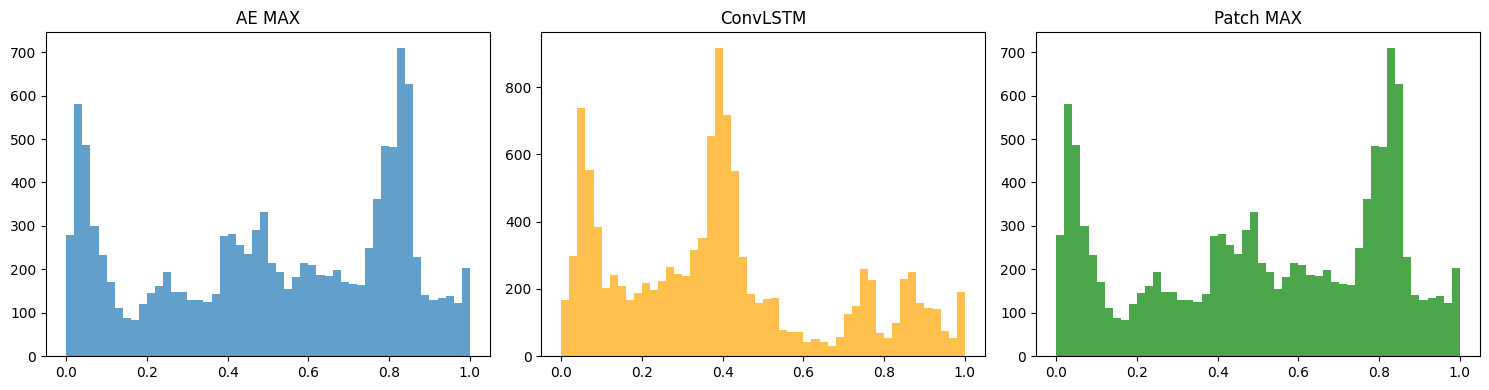

In [20]:
# Score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(list(ae_max_norm.values()), bins=50, alpha=0.7)
axes[0].set_title('AE MAX')

axes[1].hist(list(lstm_norm.values()), bins=50, alpha=0.7, color='orange')
axes[1].set_title('ConvLSTM')

axes[2].hist(list(patch_norm.values()), bins=50, alpha=0.7, color='green')
axes[2].set_title('Patch MAX')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'distributions.png'))
plt.show()

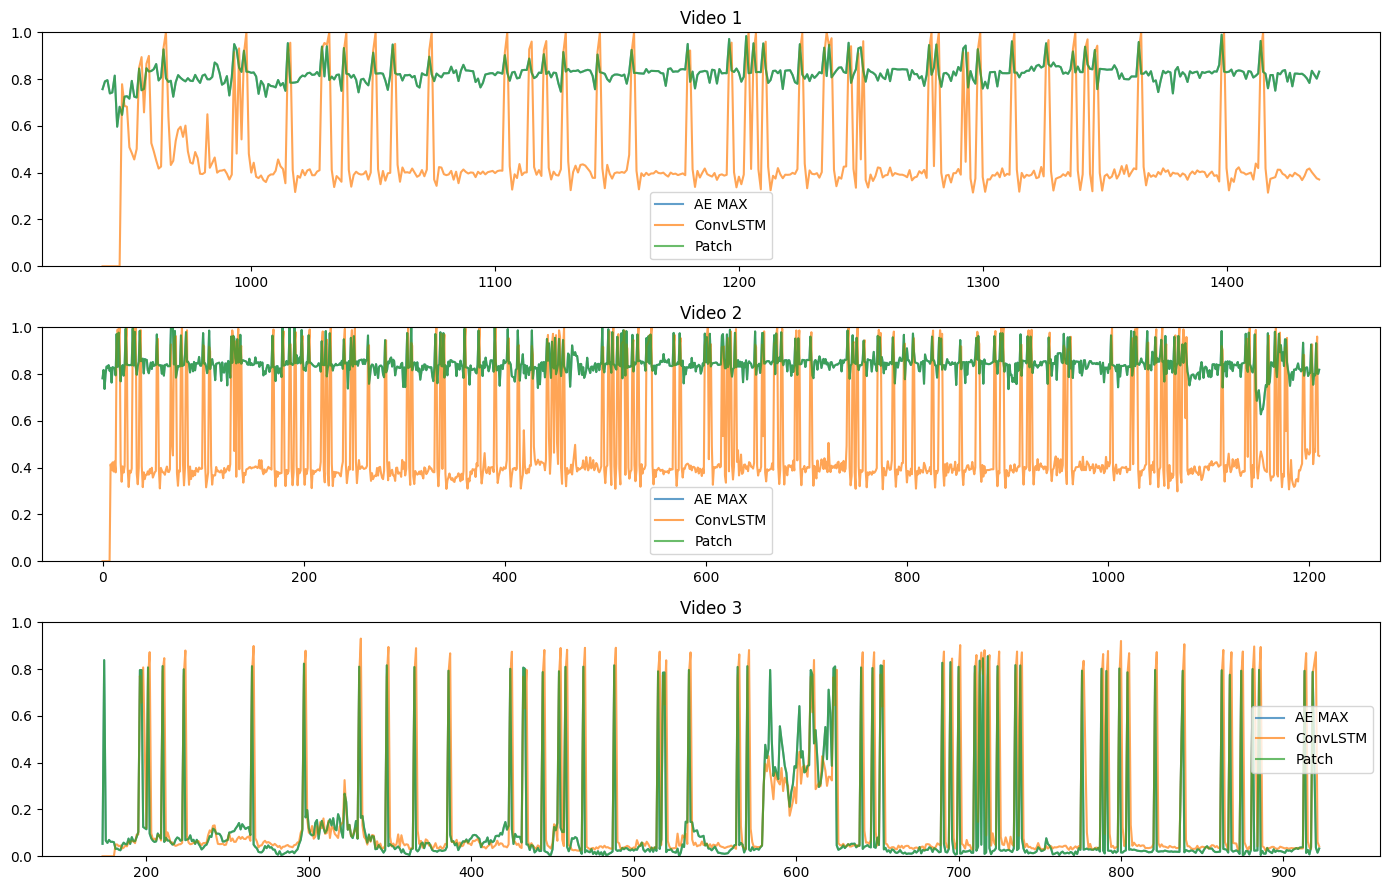

In [21]:
# Temporal plots
n_vids = min(3, len(test_by_video))
fig, axes = plt.subplots(n_vids, 1, figsize=(14, 3*n_vids))
if n_vids == 1:
    axes = [axes]

for idx, vid in enumerate(sorted(test_by_video.keys())[:n_vids]):
    fnums = test_by_video[vid]['fnums']
    ae_s = [ae_max_norm.get(f"{vid}_{f}", 0) for f in fnums]
    lstm_s = [lstm_norm.get(f"{vid}_{f}", 0) for f in fnums]
    patch_s = [patch_norm.get(f"{vid}_{f}", 0) for f in fnums]
    
    axes[idx].plot(fnums, ae_s, label='AE MAX', alpha=0.7)
    axes[idx].plot(fnums, lstm_s, label='ConvLSTM', alpha=0.7)
    axes[idx].plot(fnums, patch_s, label='Patch', alpha=0.7)
    axes[idx].set_title(f'Video {vid}')
    axes[idx].legend()
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal.png'))
plt.show()

In [22]:
# Cleanup
del train_tensors, test_tensors
gc.collect()
torch.cuda.empty_cache()
print("Done!")

Done!
